In [1]:
import pandas as pd
import numpy as np
from random import sample
from feature_prep import feature_construction
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("aimed_left-features.csv")

In [4]:
predictors = ['xpos_ball', 'xpos_pad', 'score', 'pad_width', 'ball_speed', 'ball_down',
              'l2_ball_pad', 'num_bricks_left', 'num_cols_0_bricks',
              'num_cols_1_brick', 'num_cols_2_bricks', 'bricks_right_of_paddle', 'bricks_left_of_paddle', 'channels_left_of_paddle',
              'channels_right_of_paddle', 'almost_channels_left_of_paddle', 'almost_channels_right_of_paddle']

In [5]:
for predictor in predictors:
    if isinstance(df[predictor][0], (np.bool_, bool)):
        # convert booleans to 0/1 rather than 'True'/'False'
        df[predictor] = [1 if val == 'True' else 0 for val in df[predictor]]
    if isinstance(df[predictor][0], str):
        if len(np.unique(df[predictor])) > 2:
            print("warning: " + predictor + " should be converted into numbers")
        else:  # don't discretize, just convert to integer values, since order is irrelevant if there are only two possible values
            df[predictor] = [1 if val == df[predictor][0] else 0 for val in df[predictor]]

In [6]:
cor = np.corrcoef(df[predictors].T)

/Users/kentatakatsu/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kentatakatsu/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


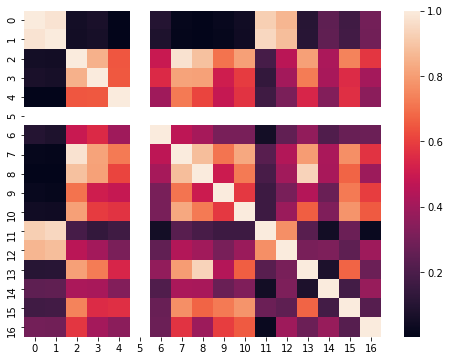

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(np.abs(cor))

In [9]:
for i in range(len(cor)):
    for j in range(i+1, len(cor)):
        if np.abs(cor[i, j]) > 0.85:
            print(i,j)
# xpos_ball and xpos_pad
# num_cols_0_bricks and channels_left_of_paddle

0 1
0 11
1 11
2 7
8 13


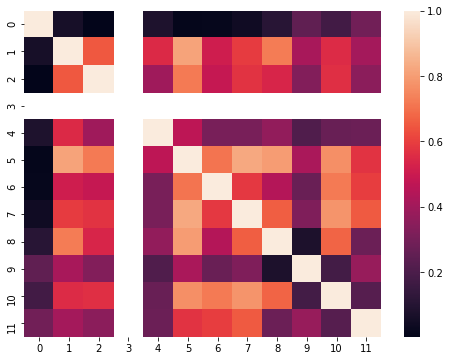

In [268]:
plt.figure(figsize=(8,6))
predictors_ = [item for i, item in enumerate(predictors) if i not in (0,2,8,11,12)]
cor = np.corrcoef(df[predictors_].T)
sns.heatmap(np.abs(cor))

In [269]:
num_pos_samples_per_episode = 20
num_neg_samples_per_episode = 20
time_lag = 6
samples = []

seeds = np.unique(df['seed'])
np.random.shuffle(seeds)

train_seed = seeds[:24]
for seed in train_seed:
    df_seed = df[df.seed == seed]
    positive_samples_t = df_seed[df_seed.outcome & (df_seed.t >= time_lag)].t.values - time_lag
    positive_samples_t = sample(list(positive_samples_t), min(num_pos_samples_per_episode, len(positive_samples_t)))
    positive_samples = df_seed[[t in positive_samples_t for t in df_seed.t]]
    positive_samples = positive_samples.assign(outcome=True)

    negative_samples_t = df_seed[
                             ~df_seed.outcome & df_seed.outcome_indicator & (df_seed.t >= time_lag)].t.values - time_lag
    negative_samples_t = sample(list(negative_samples_t), min(num_neg_samples_per_episode, len(negative_samples_t)))
    negative_samples = df_seed[[t in negative_samples_t for t in df_seed.t]]
    negative_samples = negative_samples.assign(outcome=False)

    samples.append(positive_samples)
    samples.append(negative_samples)
samples = pd.concat(samples)

print(samples.shape)

val_samples = []
val_seed = seeds[24:]
for seed in val_seed:
    df_seed = df[df.seed == seed]
    positive_samples_t = df_seed[df_seed.outcome & (df_seed.t >= time_lag)].t.values - time_lag
    positive_samples_t = sample(list(positive_samples_t), min(num_pos_samples_per_episode, len(positive_samples_t)))
    positive_samples = df_seed[[t in positive_samples_t for t in df_seed.t]]
    positive_samples = positive_samples.assign(outcome=True)

    negative_samples_t = df_seed[
                             ~df_seed.outcome & df_seed.outcome_indicator & (df_seed.t >= time_lag)].t.values - time_lag
    negative_samples_t = sample(list(negative_samples_t), min(num_neg_samples_per_episode, len(negative_samples_t)))
    negative_samples = df_seed[[t in negative_samples_t for t in df_seed.t]]
    negative_samples = negative_samples.assign(outcome=False)

    val_samples.append(positive_samples)
    val_samples.append(negative_samples)
val_samples = pd.concat(val_samples)

print(val_samples.shape)

(352, 58)
(77, 58)


In [270]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(samples[predictors_], samples['outcome'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [271]:
sum(rf.predict(samples[predictors_]) == samples['outcome'])/ len(samples['outcome'])

0.9943181818181818

In [272]:
val_pred = rf.predict(val_samples[predictors_])
sum(val_pred.astype(np.float64) == val_samples['outcome'])/ len(val_samples['outcome'])

0.8051948051948052

In [273]:
val_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [274]:
# initial prediction for E[Y|T,X] using SuperLearner
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

ensemble = SuperLearner(scorer=accuracy_score, verbose=2)
ensemble.add([RandomForestClassifier(n_estimators=100), 
              SVC(), 
              LogisticRegression(), 
              GaussianNB(), 
              KNeighborsClassifier()])
ensemble.add_meta(LogisticRegression())
ensemble.fit(samples[predictors_], samples['outcome'])
preds = ensemble.predict(val_samples[predictors_])


Fitting 2 layers
Processing layer-1             

/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:00

Predicting 2 layers


/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [275]:
sum(preds.astype(np.float64) == val_samples['outcome'])/ len(val_samples['outcome'])

0.8181818181818182

In [276]:
from xbart import XBART

xbt = XBART(model="Probit", num_trees = 1000, num_sweeps = 100, burnin = 10)
xbt.fit(samples[predictors_], samples['outcome'].astype(np.float64))

XBART(num_trees = 1000, num_sweeps = 100, n_min = 1, num_cutpoints = 100, alpha = 0.95, beta = 1.25, tau = 0.001, burnin = 10, mtry = 12, max_depth_num = 250, kap = 16.0, s = 4.0, verbose = False, parallel = False, seed = 0, model_num = 2, no_split_penality = 0.0, sample_weights_flag = True, num_classes = 1)

In [277]:
preds = (xbt.predict(val_samples[predictors_])> 0.5)*1
sum(preds == val_samples['outcome'].astype(np.float64))/ len(val_samples['outcome'])

0.8181818181818182

In [278]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [279]:
num_discretization_bins = 5

discretization_dict = dict()
for predictor in tqdm(predictors_):
    if isinstance(df[predictor][0], float) | len(pd.unique(df[predictor])) > 8:
        not_discretized_yet = True
        curr_num_bins = 1
        while not_discretized_yet:
            try:
                if curr_num_bins == 1:  # we can't do a single bin, so give up on density-based binning
                    discretization = list(pd.cut(df[predictor], bins=num_discretization_bins))
                else:
                    discretization = list(pd.qcut(df[predictor], q=curr_num_bins))
                discretization_dict[predictor] = sorted(np.unique(discretization))  # save the discretization scheme
                discretization_dict[predictor] = sorted(np.unique(discretization))
                not_discretized_yet = False

            except ValueError:
                curr_num_bins -= 1

In [280]:
discretization_dict

{'xpos_pad': [Interval(-0.24, 48.0, closed='right'),
  Interval(48.0, 96.0, closed='right'),
  Interval(96.0, 144.0, closed='right'),
  Interval(144.0, 192.0, closed='right'),
  Interval(192.0, 240.0, closed='right')],
 'l2_ball_pad': [Interval(0.881, 25.075, closed='right'),
  Interval(25.075, 49.148, closed='right'),
  Interval(49.148, 73.222, closed='right'),
  Interval(73.222, 97.296, closed='right'),
  Interval(97.296, 121.369, closed='right')],
 'num_bricks_left': [Interval(25.918, 42.4, closed='right'),
  Interval(42.4, 58.8, closed='right'),
  Interval(58.8, 75.2, closed='right'),
  Interval(75.2, 91.6, closed='right'),
  Interval(91.6, 108.0, closed='right')],
 'num_cols_1_brick': [Interval(-0.009, 1.8, closed='right'),
  Interval(1.8, 3.6, closed='right'),
  Interval(3.6, 5.4, closed='right'),
  Interval(5.4, 7.2, closed='right'),
  Interval(7.2, 9.0, closed='right')],
 'num_cols_2_bricks': [Interval(-0.008, 1.6, closed='right'),
  Interval(1.6, 3.2, closed='right'),
  Interv

In [281]:
# ### Learn joint model of covariates, in the form of separate predictive random forests for each covariate
rf_dict = dict()
for covar in tqdm(predictors_):
    print(covar)
    if covar in discretization_dict.keys():  # need to apply discretization scheme to the current covar
        discretization = discretization_dict[covar]
        val_to_discretize = samples[covar]
        val_discretized = []
        for val in val_to_discretize:
            is_disc_value = [val in disc for disc in
                             discretization]  # figure out which discretization category the value is in
            val_discretized.append(
                discretization[np.where(is_disc_value)[0][0]])  # get the actual interval corresponding to that location
        curr_outcome = [str(val) for val in val_discretized]
    else:
        curr_outcome = samples[covar]
    rf_dict[covar] = RandomForestClassifier(n_estimators=100)
    rf_dict[covar].fit(samples[predictors_].loc[:, samples[predictors_].columns != covar], curr_outcome)

xpos_pad
pad_width
ball_speed
ball_down
l2_ball_pad
num_bricks_left
num_cols_1_brick
num_cols_2_bricks
channels_left_of_paddle
channels_right_of_paddle
almost_channels_left_of_paddle
almost_channels_right_of_paddle



In [282]:
# ### Now that we've learned all the relevant models, we can finally provide counterfactual explanations!
# - take in a query time point (must satisfy outcome_indicator)
# - apply the time lag
# - iterate over all possible (discretized) values for all predictors
# - for each value, check if the predicted outcome crosses over the .5 threshold to give a different prediction
# - if so, this is an explanation - report the likelihood of this explanation using the corresponding covariate model#



query = df.loc[sample(list(df[df.outcome_indicator].index), 1)]
print(query)
query_tick = list(query.t)[0]
query_seed = list(query.seed)[0]
observed_outcome = list(query.outcome)[0]

if query_tick - time_lag < 0:
    print("ERROR - invalid query time (too early in episode)")

# apply the time lag
query = df[(df.t == (query_tick - time_lag)) & (df.seed == query_seed)]
query.outcome = observed_outcome

possible_explanations = pd.DataFrame(columns=['variable', 'from_value', 'to_value', 'relative_prob'])
pred_outcome = rf.predict(query[predictors_])[0]
if pred_outcome != observed_outcome:
    print("Unexpected outcome - model prediction differs from observation")

for var in predictors_:
    observed_val = query[var].iloc[0]
    if var in discretization_dict.keys():
        possible_ranges = discretization_dict[var].copy()
        observed_val = possible_ranges[np.where([(observed_val in curr_range) for curr_range in possible_ranges])[0][0]]
        possible_ranges.remove(observed_val)
        # sample from the ranges to get actual values for intervention
        possible_vals = [np.random.uniform(curr_range.left, curr_range.right) for curr_range in possible_ranges]
    else:
        #        print(var + " was not discretized!")
        possible_vals = list(np.unique(df[var]))
        possible_vals.remove(observed_val)

    # loop over the possible different values for var, and see if they change the predicted outcome
    vals_with_different_outcome = []
    for val in possible_vals:
        intervened_covars = query.copy(deep=True)
        outcome_probs = rf.predict_proba(query[predictors_])
        intervened_covars[var] = val
        intervened_outcome = rf.predict(intervened_covars[predictors_])
        intervened_prob = rf.predict_proba(intervened_covars[predictors_])

        if intervened_outcome != observed_outcome:
            vals_with_different_outcome.append(val)
        print(intervened_prob)


    if len(vals_with_different_outcome) == 0:
        print("No interventions found for " + str(var))
    else:
        print("These settings of " + str(var) + " change the outcome: " + str(vals_with_different_outcome))

    # Now apply the covariate model to get the relative probabilities of these new values for var
    covar_rf = rf_dict[var]
    covar_classes = [str(curr_class) for curr_class in list(covar_rf.classes_)]
    for val in vals_with_different_outcome:
        if var in discretization_dict.keys():
            val = possible_ranges[np.where([(val in curr_range) for curr_range in possible_ranges])[0][0]]
        model_preds = covar_rf.predict_proba(query[predictors].loc[:, query[predictors].columns != var])[0]
        observed_prob = model_preds[covar_classes.index(str(observed_val))]
        if ~(val in covar_classes):
            intervened_prob = 0
        else:
            intervened_prob = model_preds[covar_classes.index(str(val))]
        if observed_prob == 0:
            change_prob = 0
        else:
            change_prob = intervened_prob / observed_prob
        possible_explanations.loc[len(possible_explanations)] = [var, observed_val, val, change_prob]

print(possible_explanations)


      agent_name     seed    t action  missed_ball   xpos_ball  ypos_ball  \
19302     Target  4561254  216  right        False  162.309287      142.0   

       xpos_ball_prev  ypos_ball_prev  xpos_pad  ...  channels_left_of_paddle  \
19302      162.309287           140.0     156.0  ...                        0   

       channels_right_of_paddle  almost_channels_left_of_paddle  \
19302                         0                               0   

      almost_channels_right_of_paddle  ball_down_prev  ball_hit  aimed_left  \
19302                               0            True      True       False   

       aimed_right  outcome  outcome_indicator  
19302         True    False               True  

[1 rows x 58 columns]


/Users/kentatakatsu/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[[0.998 0.002]]
[[0.952 0.048]]
[[0.874 0.126]]
[[0.801 0.199]]
No interventions found for xpos_pad
[[0.915 0.085]]
No interventions found for pad_width
[[0.851 0.149]]
No interventions found for ball_speed
No interventions found for ball_down
[[0.933 0.067]]
[[0.933 0.067]]
[[0.933 0.067]]
[[0.933 0.067]]
No interventions found for l2_ball_pad
[[0.692 0.308]]
[[0.686 0.314]]
[[0.697 0.303]]
[[0.757 0.243]]
No interventions found for num_bricks_left
[[0.928 0.072]]
[[0.928 0.072]]
[[0.928 0.072]]
[[0.928 0.072]]
No interventions found for num_cols_1_brick
[[0.768 0.232]]
[[0.779 0.221]]
[[0.779 0.221]]
[[0.779 0.221]]
No interventions found for num_cols_2_bricks
[[0.923 0.077]]
[[0.915 0.085]]
[[0.914 0.086]]
[[0.899 0.101]]
[[0.898 0.102]]
[[0.899 0.101]]
No interventions found for channels_left_of_paddle
[[0.957 0.043]]
[[0.958 0.042]]
[[0.958 0.042]]
No interventions found for channels_right_of_paddle
[[0.874 0.126]]
[[0.863 0.137]]
[[0.863 0.137]]
[[0.863 0.137]]
No interventions f

In [285]:
# ### Now that we've learned all the relevant models, we can finally provide counterfactual explanations!
# - take in a query time point (must satisfy outcome_indicator)
# - apply the time lag
# - iterate over all possible (discretized) values for all predictors
# - for each value, check if the predicted outcome crosses over the .5 threshold to give a different prediction
# - if so, this is an explanation - report the likelihood of this explanation using the corresponding covariate model#



query = df.loc[sample(list(df[df.outcome_indicator].index), 1)]
print(query)
query_tick = list(query.t)[0]
query_seed = list(query.seed)[0]
observed_outcome = list(query.outcome)[0]

if query_tick - time_lag < 0:
    print("ERROR - invalid query time (too early in episode)")

# apply the time lag
query = df[(df.t == (query_tick - time_lag)) & (df.seed == query_seed)]
query.outcome = observed_outcome

possible_explanations = pd.DataFrame(columns=['variable', 'from_value', 'to_value', 'relative_prob'])
pred_outcome = xbt.predict(query[predictors_])[0]
if pred_outcome != observed_outcome:
    print("Unexpected outcome - model prediction differs from observation")

for var in predictors_:
    observed_val = query[var].iloc[0]
    if var in discretization_dict.keys():
        possible_ranges = discretization_dict[var].copy()
        observed_val = possible_ranges[np.where([(observed_val in curr_range) for curr_range in possible_ranges])[0][0]]
        possible_ranges.remove(observed_val)
        # sample from the ranges to get actual values for intervention
        possible_vals = [np.random.uniform(curr_range.left, curr_range.right) for curr_range in possible_ranges]
    else:
        #        print(var + " was not discretized!")
        possible_vals = list(np.unique(df[var]))
        possible_vals.remove(observed_val)

    # loop over the possible different values for var, and see if they change the predicted outcome
    vals_with_different_outcome = []
    for val in possible_vals:
        intervened_covars = query.copy(deep=True)
        intervened_covars[var] = val
        intervened_outcome = xbt.predict(intervened_covars[predictors_])
        intervened_prob = xbt.predict(intervened_covars[predictors_])
        outcome_probs = xbt.predict(query[predictors_])

        if intervened_outcome != observed_outcome:
            vals_with_different_outcome.append(val)
        print(intervened_prob)


    if len(vals_with_different_outcome) == 0:
        print("No interventions found for " + str(var))
    else:
        print("These settings of " + str(var) + " change the outcome: " + str(vals_with_different_outcome))

    # Now apply the covariate model to get the relative probabilities of these new values for var
    covar_rf = rf_dict[var]
    covar_classes = [str(curr_class) for curr_class in list(covar_rf.classes_)]
    for val in vals_with_different_outcome:
        if var in discretization_dict.keys():
            val = possible_ranges[np.where([(val in curr_range) for curr_range in possible_ranges])[0][0]]
        model_preds = covar_rf.predict_proba(query[predictors_].loc[:, query[predictors_].columns != var])[0]
        observed_prob = model_preds[covar_classes.index(str(observed_val))]
        if ~(val in covar_classes):
            intervened_prob = 0
        else:
            intervened_prob = model_preds[covar_classes.index(str(val))]
        if observed_prob == 0:
            change_prob = 0
        else:
            change_prob = intervened_prob / observed_prob
        possible_explanations.loc[len(possible_explanations)] = [var, observed_val, val, change_prob]

print(possible_explanations)


      agent_name     seed     t action  missed_ball   xpos_ball   ypos_ball  \
36278     Target  9654690  1952   left        False  138.467616  140.172909   

       xpos_ball_prev  ypos_ball_prev  xpos_pad  ...  channels_left_of_paddle  \
36278      140.094562      136.518727     136.0  ...                        6   

       channels_right_of_paddle  almost_channels_left_of_paddle  \
36278                         0                               4   

      almost_channels_right_of_paddle  ball_down_prev  ball_hit  aimed_left  \
36278                               5            True      True       False   

       aimed_right  outcome  outcome_indicator  
36278         True    False               True  

[1 rows x 58 columns]
Unexpected outcome - model prediction differs from observation
[-556.60684255]
[-556.61309128]
[-556.6177034]
[-556.62075471]
These settings of xpos_pad change the outcome: [43.97803562124557, 88.65130848015464, 126.9590648708975, 198.47810089910072]
[-556.614638

/Users/kentatakatsu/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[-554.03490664]
These settings of ball_speed change the outcome: [1]
No interventions found for ball_down
[-556.61841628]
[-556.61841628]
[-556.61841628]
[-556.61841628]
These settings of l2_ball_pad change the outcome: [44.23465631755427, 70.11034677127546, 94.78183220352372, 102.00590040083434]
[-556.6218394]
[-556.62125605]
[-556.61952463]
[-556.61588101]
These settings of num_bricks_left change the outcome: [55.25745797065487, 73.97073171266254, 82.64046252686225, 105.72308413537262]
[-556.61415218]
[-556.61332477]
[-556.61332477]
[-556.61332477]
These settings of num_cols_1_brick change the outcome: [2.909129495798327, 4.917932034446867, 7.0402593584865505, 8.729539495065463]
[-556.61848646]
[-556.61998385]
[-556.62174549]
[-556.6202373]
These settings of num_cols_2_bricks change the outcome: [0.8817977241203181, 2.26385067730104, 3.364813400063846, 5.043958490033508]
[-556.62370697]
[-556.62266522]
[-556.61989541]
[-556.61957866]
[-556.6194525]
[-556.6194525]
These settings of ch